In [2]:
using CABLAB

INFO: Recompiling stale cache file /Net/Groups/BGI/people/fgans/julia_alt_packages/lib/v0.5/CABLAB.ji for module CABLAB.


In this study we investigate the redundancy the different variables in each pixel. Therefore we calculate a linear dimensionality reduction (PCA) and check how many dimensions are needed to explain 90% of the variance of a cube that contained originally 6 variables.  First we check out the variables from the cube and add some processors, because we want to do a global study

In [5]:
c     = Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res/")
vars  = ["gross_primary_productivity","Rg","air_temperature_2m","fpar_fluxcom","terrestrial_ecosystem_respiration","burnt_area"];
cdata = getCubeData(c,variable=vars,longitude=(-10,30),latitude=(35,65));

In [6]:
addprocs(10)

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [7]:
CABLAB.DAT.init_DATworkers()

We perform some gapfilling, because the pca does not work with gaps

In [8]:
@time cube_filled     = mapCube(gapFillMSC,cdata);

 58.027069 seconds (15.45 M allocations: 637.624 MB, 0.68% gc time)


And we calculate the anomalies

In [9]:
@time cubeanom        = mapCube(removeMSC,cube_filled)

  4.063271 seconds (184.31 k allocations: 7.184 MB, 0.50% gc time)


Temporary Data Cube with the following dimensions
time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
longitude           Axis with 160 Elements from -10.0 to 29.75
latitude            Axis with 120 Elements from 65.0 to 35.25
VariableAxis        Axis with elements: gross_primary_productivity Rg air_temperature_2m fpar_fluxcom terrestrial_ecosystem_respiration burnt_area 


In [16]:
@everywhere using MultivariateStats
@everywhere function sufficient_dimensions{T}(xout::AbstractArray{T}, xin::AbstractArray{T}, expl_var::Float64 = 0.95)
    if mapreduce(isnan,+,0,xin)>0
        return xout[1]=NaN
    end
    npoint, nvar = size(xin)
    for i in 1:nvar
        _sum  = _ssum = zero(eltype(xin))
        for j in 1:npoint
            _sum  += xin[j,i]
            _ssum += xin[j,i]^2
        end
        _mean  = _sum / npoint
        _smean = _ssum / npoint
        _std = sqrt(_smean - _mean^2 > 0.0 ? _smean-_mean^2 : zero(typeof(_mean)))
        if _std == 0
            _std = 1.0
            #warn("zero variance in column $i")
        end
        for j in 1:npoint
            xin[j,i] -= _mean
            xin[j,i] /= _std
        end
    end
    pca = fit(PCA, xin, pratio = 0.999, method = :svd)
    xout[1]  =
        findfirst(cumsum(principalvars(pca)) / tprincipalvar(pca) .> expl_var)
    xout[1]
end 
registerDATFunction(sufficient_dimensions,(TimeAxis,VariableAxis),(),inmissing=(:nan,),outmissing=:nan,no_ocean=1)

Any, N<:Any}) in module Main at In[10]:3 overwritten at In[16]:3.
Any, N<:Any}, Float64) in module Main at In[10]:3 overwritten at In[16]:3.


CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.TimeAxis,CABLAB.Cubes.Axes.VariableAxis),),(),(),Any,(:nan,),:nan,1,true)

First we doe the analysis on the original cube:

In [18]:
@time qualitypca=mapCube(sufficient_dimensions,cube_filled,0.90);

  1.354501 seconds (26.80 k allocations: 1.378 MB)


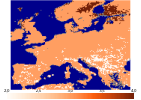

In [19]:
plotMAP(qualitypca)

And on the anomalies only:

In [ ]:
qualitypcaanom=mapCube(sufficient_dimensions,cubeanom,0.90);

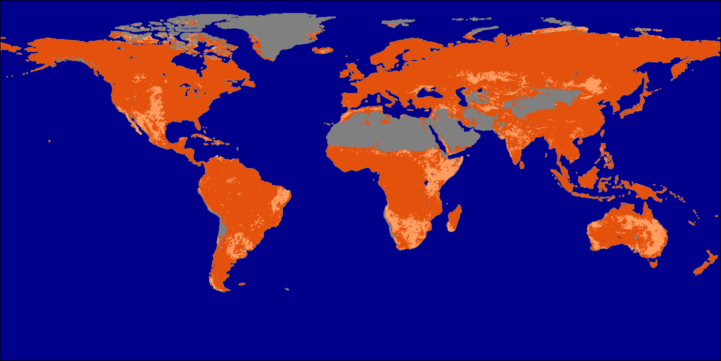

In [17]:
plotMAP(qualitypcaanom,dmin=1.f0,dmax=5.f0)

In [5]:
rmprocs(workers())

:ok